<a href="https://colab.research.google.com/github/dw2761/tech-presentation/blob/main/demo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# PyTorch基础

直接用Python训练神经网络会很复杂，但我们可以通过一些库来帮助我们训练、构建神经网络。这些库当中最常用的是PyTorch。PyTorch是由Meta AI(Facebook)人工智能研究小组开发的一种基于Lua编写的Torch库的Python实现的深度学习库，目前被广泛应用于学术界和工业界。（除此之外还有一些其他库比如Tensorflow, Jax等）


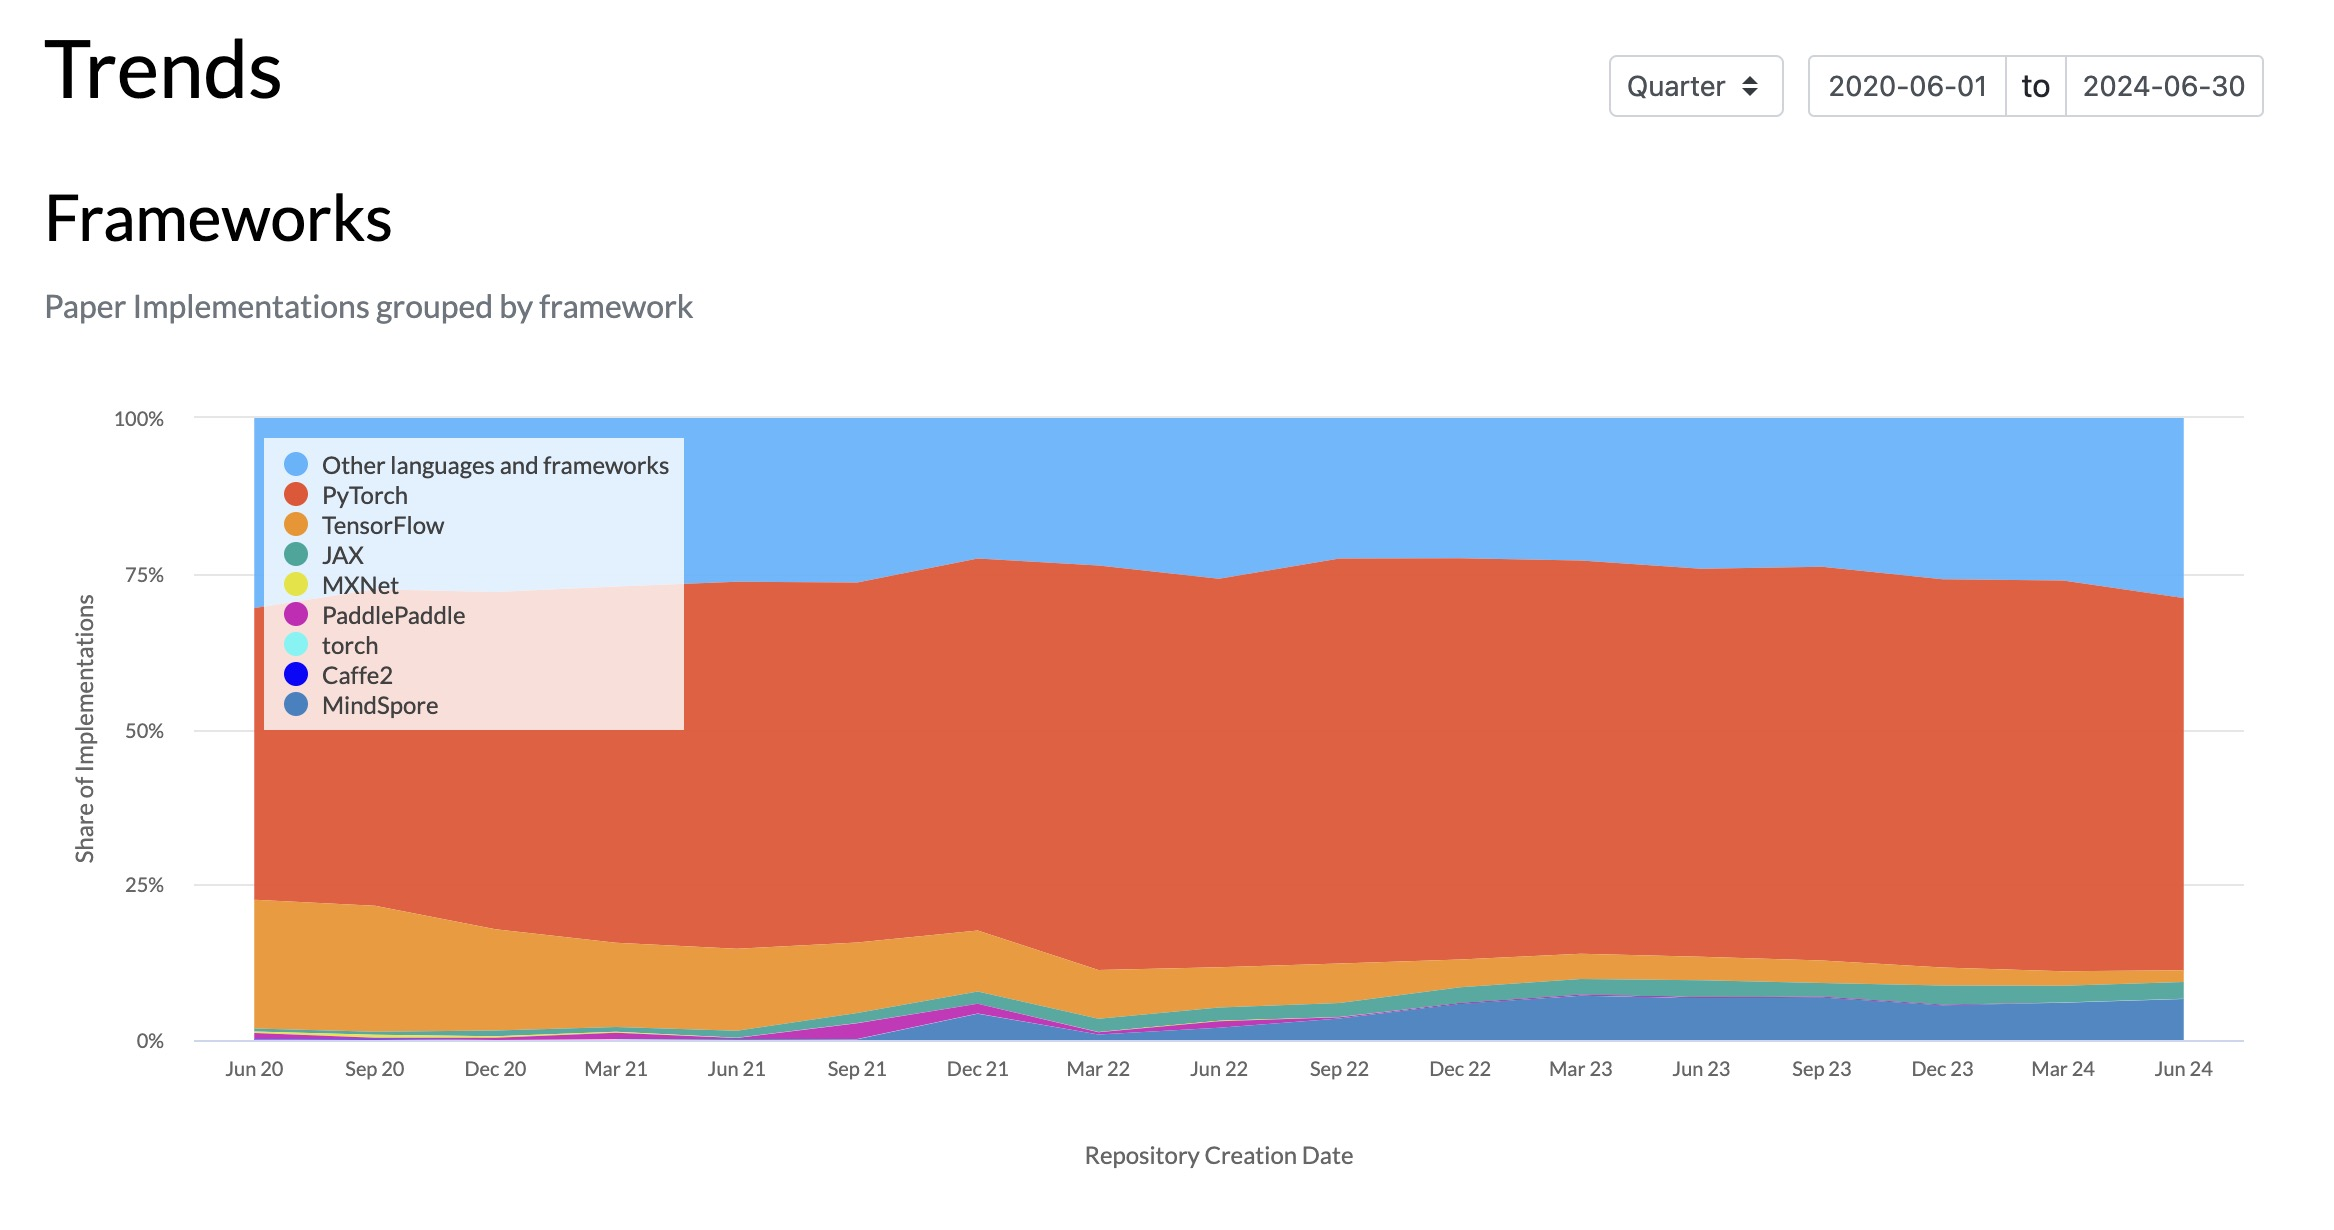

Image Source: paperswithcode.com

In [ ]:
import numpy as np
import torch
import torchvision

Torch中所有变量都是 *tensor*（张量）

In [ ]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

print(a)
print(b)

[[0.2699923  0.00205266 0.61587169]
 [0.31468103 0.44245857 0.31079955]]
tensor([[0.2700, 0.0021, 0.6159],
        [0.3147, 0.4425, 0.3108]], dtype=torch.float64)


几何代数中定义的张量是基于向量和矩阵的推广，比如我们可以将标量视为零阶张量，矢量可以视为一阶张量，矩阵就是二阶张量。张量是现代机器学习的基础。它的核心是一个数据容器，多数情况下，它包含数字，有时候它也包含字符串，但这种情况比较少。因此可以把它想象成一个数字的水桶。

训练神经网络涉及*前向*和*后向*传递，这两者本质上都是矩阵乘法，而张量允许直观且高效地跨不同索引维度进行矩阵乘法。



Torch 变量都是可微的。（可微在深度学习的反向传播中非常重要。）
我们可以通过torch.rand()的方法，构造一个随机初始化的矩阵：

In [ ]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1,requires_grad=True)

y = torch.matmul(A,x) + b

print(y)

tensor([[0.2384],
        [1.1267]], grad_fn=<AddBackward0>)


In [ ]:
z = y.sum()
print(z)

tensor(1.3651, grad_fn=<SumBackward0>)


这里，*z* 是输入 *x* 的函数。我们使用backpropagation计算 *z* 相对于 *x* 的导数。

In [ ]:
z.backward()
print(x.grad)
print(x)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

# 训练简单模型

现在让我们训练一个简单的模型。我们将在一个名为 *Fashion-MNIST* 的流行图像数据集上训练一个逻辑分类器（相当于单层神经网络）。（TorchVision 还有其他几个图像数据集，我们可以直接将其加载为变量，可以随意在这些数据集上训练你自己的模型）。

In [ ]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:03<00:00, 8087000.27it/s] 


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 136375.07it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 498091.56it/s] 


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5160678.06it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



检查是否成功下载

In [ ]:
print(len(trainingdata))
print(len(testdata))

60000
10000


绘制一张FashionMNIST中的图像。

In [ ]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


由于image对象是 Torch 张量，我们无法直接绘制它，因此在显示之前，需要先将其转换回 numpy 数组。使用 matplotlib 来显示图像。

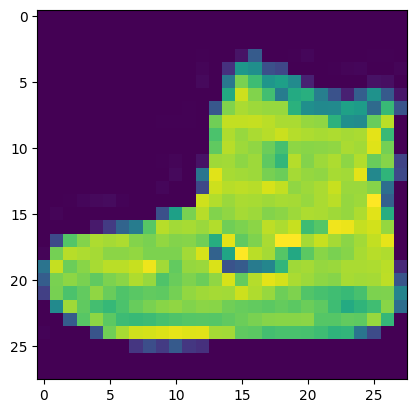

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze().numpy())
plt.show()

FashionMNIST 基本上是一堆不同衣服的黑白缩略图。让我们试着绘制其中的一些。要遍历数据集，可以构建一个 *DataLoader* 对象；我们也将在下面的训练模型时使用它。

In [ ]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

现在我们来构建模型。

In [ ]:
class SimpleNet(torch.nn.Module):
  def __init__(self):
    super(SimpleNet, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = SimpleNet().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

模型构建好了，现在我们来训练这个神经网络。

In [ ]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.961714078273092, Test loss 0.7390286081535801
Epoch 1, Train loss 0.6675478938355375, Test loss 0.6450762162163
Epoch 2, Train loss 0.6036787949073543, Test loss 0.6059941450122056
Epoch 3, Train loss 0.5689637869088127, Test loss 0.5778102631781511
Epoch 4, Train loss 0.5459472979627439, Test loss 0.5603059854856722
Epoch 5, Train loss 0.5295052317096226, Test loss 0.5471355645519913
Epoch 6, Train loss 0.5168775302896114, Test loss 0.536883752626978
Epoch 7, Train loss 0.5064954259184632, Test loss 0.5279368074836245
Epoch 8, Train loss 0.4982258925305755, Test loss 0.5216981261778789
Epoch 9, Train loss 0.49097844786735484, Test loss 0.516638484540259
Epoch 10, Train loss 0.48470589412110193, Test loss 0.5116841286230999
Epoch 11, Train loss 0.479280294512889, Test loss 0.5057941428415335
Epoch 12, Train loss 0.4746379666427559, Test loss 0.5014773151677125
Epoch 13, Train loss 0.4704286928401827, Test loss 0.4974520267195003
Epoch 14, Train loss 0.466542422549

通过train_loss和test_loss绘制图表。

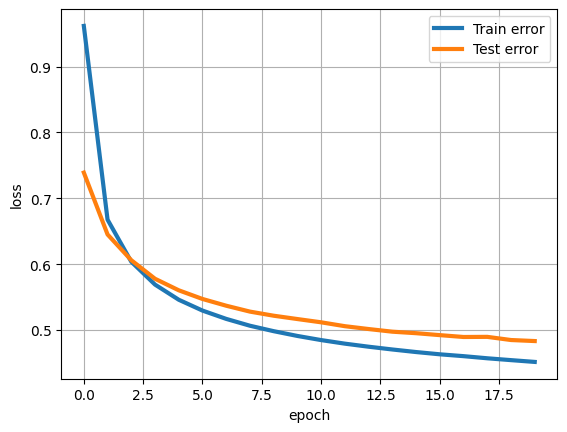

In [ ]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

我们这里实际上只训练了20个epoch，但是可以从图像上看出train_loss和test_loss都有收敛的趋势了。我们可以在一部分数据上进行预测，看看这个模型的表现。

In [ ]:
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)
print(fit)

torch.return_types.max(
values=tensor([ 6.3953,  2.9770,  9.1430,  7.6800,  6.7382,  6.4743, 10.1320,  4.4039,
         7.2079, 11.7435, 10.5401, 10.3788,  6.7762,  4.7556,  9.2677,  4.5473],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0'))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
tensor(0.3383, device='cuda:0', grad_fn=<NllLossBackward0>)


在这批图像中有 2 幅被错误分类了，让我们以人类的视角来看一下具体是哪几张。

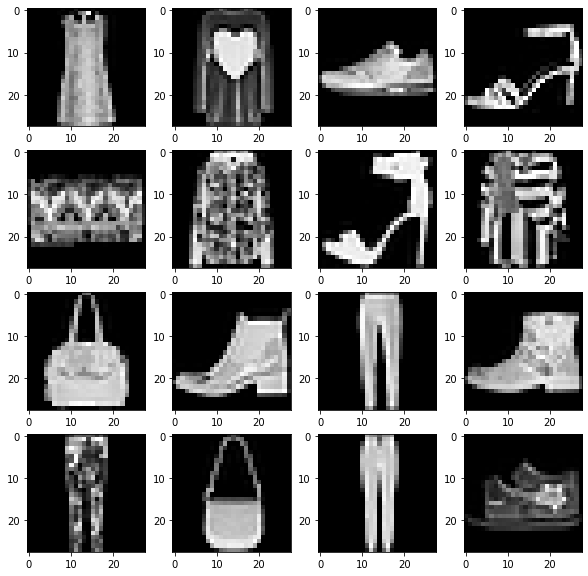

In [ ]:
plt.figure(figsize=(10,10))
for index in np.arange(0,16):
  plt.subplot(4,4,index+1)
  plt.imshow(images[index].cpu().squeeze().numpy(),cmap=plt.cm.gray)